<a href="https://colab.research.google.com/github/RubinDaija/epfl-ada-2019-project/blob/master/project-violations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Necessary Imports**

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from scipy import stats
from folium.plugins import MarkerCluster
import warnings
import folium
import zipfile

In [2]:
# ---------- Only to be run the first time the data set is uploaded ---------- #
# Reads from compressed folder, drops the irrelevant columns, and outputs the new data to a new file called food_inspections.csv

'''
zf = zipfile.ZipFile('chicago-food-inspections.zip')
dblp = pd.read_csv(zf.open('chicago-food-inspections/food-inspections.csv'))
dblp = dblp.drop(['AKA Name', 'Address','City','State','Location','Historical Wards 2003-2015','Zip Codes','Community Areas','Census Tracts','Wards'], axis=1)
dblp.to_csv(r'food_inspections.csv')
'''

"\nzf = zipfile.ZipFile('chicago-food-inspections.zip')\ndblp = pd.read_csv(zf.open('chicago-food-inspections/food-inspections.csv'))\ndblp = dblp.drop(['AKA Name', 'Address','City','State','Location','Historical Wards 2003-2015','Zip Codes','Community Areas','Census Tracts','Wards'], axis=1)\ndblp.to_csv(r'food_inspections.csv')\n"

In [3]:
#-- Uncomment this if using Jupyter Lab / Comment this if using Google Colab --#
'''
zf = zipfile.ZipFile('chicago_dropped.zip')
df = pd.read_csv(zf.open('chicago_dropped/food_inspections.csv'))
'''

"\nzf = zipfile.ZipFile('chicago_dropped.zip')\ndf = pd.read_csv(zf.open('chicago_dropped/food_inspections.csv'))\n"

In [0]:
#-- Uncomment this if using Google Colab / Comment this if using Jupyter Lab --# 
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
#-- Uncomment this if using Google Colab / Comment this if using Jupyter Lab --# 
link = 'https://drive.google.com/open?id=1TtnQzq_WhnRj7KweW4upOzrC7C3gFpRE' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('food_inspections.csv')  
df = pd.read_csv('food_inspections.csv')

# Dataset is now stored in a Pandas Dataframe

1TtnQzq_WhnRj7KweW4upOzrC7C3gFpRE


# **Preprocessing**

We realized that we will use Facility Type in most of our analysis, so we decided to drop the rows that are missing Facility Type, i.e. NaN valued rows:


In [6]:
# Cleaning the data set: removing NaN valued rows in Facility Type
print("Number of rows before removing NaNs: " + str(df['Facility Type'].size))
df.dropna(subset=['Facility Type'], inplace=True)
print("Number of rows after removing NaNs: " + str(df['Facility Type'].size))
df.reset_index(drop=True, inplace=True)

Number of rows before removing NaNs: 196030
Number of rows after removing NaNs: 191258


We decided to remove the rows that have "Not Ready" as their Results value, since this value cannot be categorized as fail/pass:

In [7]:
# Cleaning the data set: removing the rows with "Not Ready" as their Results value
print("Number of rows before removing Not Ready values: " + str(df.size))
df = df[~df.Results.str.contains("Not Ready")]
print("Number of rows after removing Not Ready values: " + str(df.size))

Number of rows before removing Not Ready values: 2486354
Number of rows after removing Not Ready values: 2463097


In [8]:
# Data set after the preprocessing operations above
df.reset_index().head()

,index,Unnamed: 0,Inspection ID,DBA Name,License #,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,0,0,2345787,"CARNICERIA LEON GUANAJUATO, INC.",1821637.0,Grocery Store,Risk 1 (High),60639.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.916960,-87.733945
1,1,1,2345790,AMSTAR FUEL & MINI MART,1426374.0,Grocery Store,Risk 2 (Medium),60651.0,2019-11-18T00:00:00.000,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.895304,-87.721129
2,2,2,2345766,ROJO GUSANO,1305286.0,Restaurant,Risk 1 (High),60625.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968390,-87.724448
3,3,3,2345702,LAKESIDE FOOD WINE SPIRITS LLC,2694148.0,Grocery Store,Risk 3 (Low),60614.0,2019-11-15T00:00:00.000,License Re-Inspection,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.929210,-87.648746
4,4,4,2345678,"NEW KNOWLEDGE LEARNING CENTER, INC.",2215898.0,Children's Services Facility,Risk 1 (High),60652.0,2019-11-15T00:00:00.000,License,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.739458,-87.702257


We removed the rows that have any value of Risk other than 1-3 and converted Risk values to only a numeric value:

In [9]:
# Cleaning the data set: removing rows with Risk value other than 1-3
df = df[df.Risk.str.contains("[1-3]",na=False)]
# Converting Risk value to numeric
df['Risk'] = df.Risk.apply(lambda x: int(x.strip('Risk')[1]))
df.head()

,Unnamed: 0,Inspection ID,DBA Name,License #,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,0,2345787,"CARNICERIA LEON GUANAJUATO, INC.",1821637.0,Grocery Store,1,60639.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.916960,-87.733945
1,1,2345790,AMSTAR FUEL & MINI MART,1426374.0,Grocery Store,2,60651.0,2019-11-18T00:00:00.000,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.895304,-87.721129
2,2,2345766,ROJO GUSANO,1305286.0,Restaurant,1,60625.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968390,-87.724448
3,3,2345702,LAKESIDE FOOD WINE SPIRITS LLC,2694148.0,Grocery Store,3,60614.0,2019-11-15T00:00:00.000,License Re-Inspection,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.929210,-87.648746
4,4,2345678,"NEW KNOWLEDGE LEARNING CENTER, INC.",2215898.0,Children's Services Facility,1,60652.0,2019-11-15T00:00:00.000,License,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.739458,-87.702257


We removed the parantheses in Facility Type entries, as some entries can be unified into the same category this way, such as (restaurant) and restaurant:

In [0]:
# More preprocessing: removing the parantheses in Facility Type entries
df['Facility Type'] = df['Facility Type'].str.lower()
df['Facility Type'] = df['Facility Type'].str.replace('[()]', '')

In [11]:
# TODO : Grocery Store and Restaurant are going to be unified
'''
dp = df[df['Facility Type'].str.contains("grocery") & df['Facility Type'].str.contains("restaurant")]
dp.loc[:,'Facility Type'] = 'grocery and restaurant'
df = df[~df['Facility Type'].str.contains("grocery") & df['Facility Type'].str.contains("restaurant")]
'''
#df = df.append(dp,ignore_index=False)


'\ndp = df[df[\'Facility Type\'].str.contains("grocery") & df[\'Facility Type\'].str.contains("restaurant")]\ndp.loc[:,\'Facility Type\'] = \'grocery and restaurant\'\ndf = df[~df[\'Facility Type\'].str.contains("grocery") & df[\'Facility Type\'].str.contains("restaurant")]\n'

# **Data Analysis**

### **Number of Unique Facilities**

In [12]:
df_unique = df.groupby(['Latitude','Longitude','DBA Name']).count()
print("Number of unique facilities: " + str(df_unique.shape[0]))

Number of unique facilities: 27373


### **Facility Type vs. Average Risk**


We analyzed the relationship between the type of facility and the average risk of that facility over all inspections:

In [0]:
# Aggregate data over Facility Type
grouped_fac = df.groupby('Facility Type')

In [14]:
# Compute average risk of each type of facility
grouped_fac_risk_mean = pd.DataFrame(grouped_fac['Risk'].mean()).reset_index()
grouped_fac_risk_mean.head()

,Facility Type,Risk
0,1005 nursing home,1.0
1,1023,1.0
2,1023 childern's service facility,1.0
3,1023 childern's service s facility,1.0
4,1023 childern's services facility,1.0


In [0]:
# TODO: unify the entries with 1023 as one type of facility

In [16]:
# Compute number of facilities in each type of facility
fac_dist = pd.DataFrame(grouped_fac.count()['Risk']).rename(columns={'Risk':'Counts'}).sort_values(by='Counts',ascending=False).reset_index()
print("Number of different types of facilities :" + str(fac_dist.size))
fac_dist.head(100)

Number of different types of facilities :868


,Facility Type,Counts
0,restaurant,129462
1,grocery store,24677
2,school,12131
3,children's services facility,3064
4,bakery,2836
...,...,...
95,custom poultry slaughter,12
96,gas station/store,12
97,riverwalk,12
98,employee kitchen,12


When we plotted the number of facilities in each type of facility vs. their average risk score, we observed no correlation between the two. We observed that the facility type with the highest number of facilities (i.e. restaurant) has a very high average risk score:

### **Facility Type Distribution**

From the bar plot below, we can clearly observe the skewed distribution in Facility Type. Most of our data consists of restaurant, grocery store, and school types of facilities:

<BarContainer object of 15 artists>

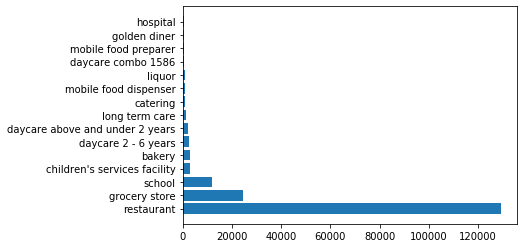

In [17]:
plt.barh(fac_dist.head(15)['Facility Type'],fac_dist.head(15)['Counts'])

### **Number of Facilities in a Type vs. Average Risk Score**

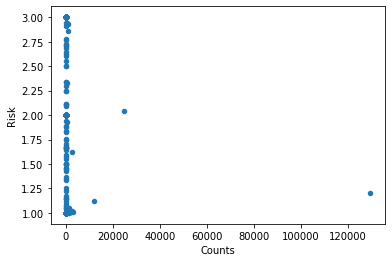

In [18]:
# Perform inner merge on number of facilities and their risk scores 
merged_inner = pd.merge(left=fac_dist,right=grouped_fac_risk_mean,left_on='Facility Type',right_on='Facility Type')
# Scatter plot: number of facilities in each type (i.e. facility type) vs. average risk score
merged_inner.plot.scatter(x='Counts', y='Risk')

We realized that the dataset is unbalanced in terms of number of Facility Types, where there are some Facility Types with very few instances. The types of facilities with very few instances would provide us with little to no information. Hence, we decided to analyze the 50 most frequent type of facilities and drop the others:

In [19]:
print("Number of entries before removing facility types with few instances: " + str(df.size))
df = df[df['Facility Type'].isin(list(fac_dist['Facility Type'])[:50])]
print("Number of entries after removing facility types with few instances: " + str(df.size))

Number of entries before removing facility types with few instances: 2462837
Number of entries after removing facility types with few instances: 2434458


As we can see from the code above, there are around 20 thousand facilities that dont have as much inspections as the others. As a result, data set is more balanced now

### **Out of Business Facilities on Map**

In [20]:
# Out of business facilities
df_oob = df[df.Results.str.contains("Out of Business",na=False)]
df_oob
# Grouped by the facilities
df_oob_unique = df_oob.groupby(['Latitude','Longitude','DBA Name', 'License #']).count()
df_oob_unique.shape

(12368, 9)

We mapped the facilities that have gone out of business to identify any possible pattern:

In [21]:
'''
# Map the facilities that have gone out of business 
map_oob = folium.Map(
    location=[41.8781, -87.6298],
    zoom_start=9
)

# We take 5000 samples to view on the map
# TODO: take randomized samples / visualize the whole data
marker_cluster = MarkerCluster().add_to(map_oob)
ranges = 0
for i in df_oob_unique.index:
    if ranges == 5000:
        break
    folium.Marker([(i[0]), (i[1])]).add_to(marker_cluster)        
    ranges = ranges + 1

map_oob
'''

'\n# Map the facilities that have gone out of business \nmap_oob = folium.Map(\n    location=[41.8781, -87.6298],\n    zoom_start=9\n)\n\n# We take 5000 samples to view on the map\n# TODO: take randomized samples / visualize the whole data\nmarker_cluster = MarkerCluster().add_to(map_oob)\nranges = 0\nfor i in df_oob_unique.index:\n    if ranges == 5000:\n        break\n    folium.Marker([(i[0]), (i[1])]).add_to(marker_cluster)        \n    ranges = ranges + 1\n\nmap_oob\n'

### **Average Risk of Facilities on Map**

In [0]:
# Calculate risk mean of each facility
df_avg_risk_score = df.groupby(['Latitude','Longitude','DBA Name'])['Risk'].mean()

We mapped the average risk score of facilities to identify any possible pattern:

In [23]:
# Map the average risk score of facilities, where red indicates high risk, orange indicates medium risk, and green indicates low risk
'''
map_risk = folium.Map(
    location=[41.8781, -87.6298],
    zoom_start=9
)

# We take 2000 samples to view on the map
# TODO: take randomized samples / visualize the whole data
ranges = 0
for i in df_avg_risk_score.index:
    if ranges == 2000:
        break
    if(round(df_avg_risk_score[i]) == 1):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='red')).add_to(map_risk)
    elif(round(df_avg_risk_score[i]) == 2):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='orange')).add_to(map_risk)
    elif(round(df_avg_risk_score[i]) == 3):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='green')).add_to(map_risk)       
    ranges = ranges + 1

map_risk
'''

"\nmap_risk = folium.Map(\n    location=[41.8781, -87.6298],\n    zoom_start=9\n)\n\n# We take 2000 samples to view on the map\n# TODO: take randomized samples / visualize the whole data\nranges = 0\nfor i in df_avg_risk_score.index:\n    if ranges == 2000:\n        break\n    if(round(df_avg_risk_score[i]) == 1):\n        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='red')).add_to(map_risk)\n    elif(round(df_avg_risk_score[i]) == 2):\n        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='orange')).add_to(map_risk)\n    elif(round(df_avg_risk_score[i]) == 3):\n        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='green')).add_to(map_risk)       \n    ranges = ranges + 1\n\nmap_risk\n"

We plotted the number of inspections vs. the average risk score of each facility to identify any possible correlation between the two. We observed the there is a negative correlation between the number of inspections and the average risk of the facility:

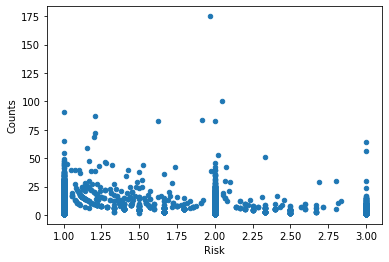

In [24]:
# Scatter plot on the number of inspections vs. the average risk score
df_unique = pd.DataFrame(df.groupby(['Latitude','Longitude','DBA Name']).count()['Risk']).rename(columns={'Risk':'Counts'})
merged = pd.merge(left=df_avg_risk_score.reset_index(),right=df_unique.reset_index(),left_on=['Latitude','Longitude','DBA Name'],right_on=['Latitude','Longitude','DBA Name'])
merged.plot.scatter(x='Risk', y='Counts')

We observed that the number of risk 3 facilities are lower than the others. Hence, we decided to plot average risk scores vs number of facilities.

### **Correlation between Number of Inspections and Average Level of Risk**

We observed a moderate positive correlation between the number of inspections and average level of risk of the facility (since Risk 1 means high risk and Risk 3 means low risk):

In [25]:
merged[['Risk', 'Counts']].corr(method='pearson')

,Risk,Counts
Risk,1.000000,-0.376107
Counts,-0.376107,1.000000


### **Distribution of Risk Scores of Facilities**

We visualized the distribution of average level of risk scores of each facility using the bar plot below:

In [26]:
# Grouped by risk scores and number of facilities
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score).apply(lambda x: round(x)).reset_index()
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score1.groupby('Risk').count()['Latitude']).rename(columns={'Latitude':'Counts'})
df_avg_risk_score1

,Counts
Risk,
1.0,15735
2.0,6840
3.0,4303


<BarContainer object of 3 artists>

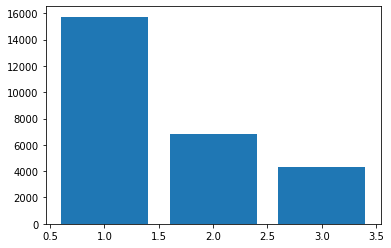

In [27]:
plt.bar(df_avg_risk_score1.index,df_avg_risk_score1['Counts'])

### **Different Branches vs. Risk Score**

For the next milestone, we want to analyze the average risk score of a facility between its different branches.

In [0]:
# Identify the facility with the highest number of branches
#grouped_name = df.groupby('DBA Name').count()
grouped_unique_name = pd.DataFrame(df.groupby('DBA Name').count().rename(columns={'Risk':'Counts'})['Counts']).sort_values(by='Counts',ascending=False).reset_index()
grouped_unique_facility = pd.DataFrame(df.groupby(['Latitude','Longitude','DBA Name']).count().rename(columns={'Risk':'Counts'})['Counts']).sort_values(by='Counts',ascending=False).reset_index()

We will be investigating the facility (chain) with the highest number of branches to see if there is any difference in the risk scores of its branches. 

In [29]:
# The facilities with the highest number of inspections (chain)
grouped_unique_name.head()

,DBA Name,Counts
0,SUBWAY,2650
1,DUNKIN DONUTS,1359
2,MCDONALD'S,561
3,7-ELEVEN,418
4,MCDONALDS,322


In [30]:
# The facilities with the highest number of inspections (unique)
grouped_unique_facility.head()

,Latitude,Longitude,DBA Name,Counts
0,41.862628,-87.615031,SPORTSERVICE SOLDIER FIELD,175
1,41.830784,-87.635296,ILLINOIS SPORTSERVICE INC,100
2,42.008536,-87.914428,THE GREAT AMERICAN BAGEL,91
3,41.883473,-87.627730,MACY'S,87
4,41.947317,-87.656418,LEVY RESTAURANTS AT WRIGLEY FIELD,84


### **Type of Facility vs. Percentage of Going Out of Business**

In [31]:
# Data grouped by the facility type
fac_dist.head()

,Facility Type,Counts
0,restaurant,129462
1,grocery store,24677
2,school,12131
3,children's services facility,3064
4,bakery,2836


In [0]:
# Group out of business facilities on facility type
df_oob_fac = pd.DataFrame(df_oob.groupby('Facility Type').count().rename(columns={'Risk':'Counts'})['Counts'])
merged_fac_oob = pd.merge(left=df_oob_fac.reset_index(), right=fac_dist.reset_index(),left_on=['Facility Type'],right_on=['Facility Type'])

In [33]:
merged_fac_oob.head()

,Facility Type,Counts_x,index,Counts_y
0,1023 childern's services facility,3,46,33
1,bakery,230,4,2836
2,banquet,1,27,75
3,banquet hall,12,20,166
4,cafeteria,5,30,56


In [0]:
merged_fac_oob['Oob Ratio'] = merged_fac_oob['Counts_x'].divide(merged_fac_oob['Counts_y'], fill_value=1)

In [35]:
merged_fac_oob.sort_values(by='Oob Ratio', ascending=False).drop(columns='index').head()

,Facility Type,Counts_x,Counts_y,Oob Ratio
10,convenience,8,52,0.153846
6,charter school,9,69,0.130435
12,daycare,6,49,0.122449
18,gas station,16,138,0.115942
16,daycare combo 1586,85,752,0.113032


In [36]:
merged_fac_oob[['Oob Ratio', 'Counts_y']].corr(method='pearson')

,Oob Ratio,Counts_y
Oob Ratio,1.000000,0.001145
Counts_y,0.001145,1.000000


We wanted to identify a possible correlation between the type of facility and the percentage of going out of business. However, when we calculated the pearson's correlation factor, we observed no correlation.

### **Percentage of Going Out of Business vs. Average Risk Score**

In [0]:
# Merge the out of business facility types with their average risk scores
fac_oob_risk = pd.merge(left=merged_fac_oob.reset_index(), right=grouped_fac_risk_mean.reset_index(),left_on=['Facility Type'],right_on=['Facility Type'])

In [38]:
fac_oob_risk.drop(columns=['index_x', 'index_y']).rename(columns={'Counts_x':'Oob Count', 'Counts_y':'Total Count'}).head()

,level_0,Facility Type,Oob Count,Total Count,Oob Ratio,Risk
0,0,1023 childern's services facility,3,33,0.090909,1.000000
1,1,bakery,230,2836,0.081100,1.622003
2,2,banquet,1,75,0.013333,1.173333
3,3,banquet hall,12,166,0.072289,1.138554
4,4,cafeteria,5,56,0.089286,1.053571


In [39]:
fac_oob_risk[['Oob Ratio', 'Risk']].corr(method='pearson')

,Oob Ratio,Risk
Oob Ratio,1.000000,0.016496
Risk,0.016496,1.000000


We wanted to identify a possible correlation between the out of business ratio and the risk of the type of facility. However, when we calculated the pearson's correlation factor, we observed no correlation.



### **Violation Type Analysis**

### **Violations analysis - facilities that have gone out of business**

In [40]:
df_oob_unique.reset_index(inplace=True)
merged_oob = pd.merge(left=df_oob_unique[['Latitude', 'Longitude', 'DBA Name', 'License #']], right=df, on=['Latitude', 'Longitude', 'DBA Name', 'License #'])
merged_oob.head(10)

,Latitude,Longitude,DBA Name,License #,Unnamed: 0,Inspection ID,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Violations
0,41.644670,-87.540095,BURGER KING #7268,1473518.0,95174,1527281,restaurant,2,60633.0,2015-02-23T00:00:00.000,Canvass,Out of Business,NaN
1,41.644670,-87.540095,BURGER KING #7268,1473518.0,105889,1494060,restaurant,2,60633.0,2014-08-26T00:00:00.000,Canvass Re-Inspection,Pass,NaN
2,41.644670,-87.540095,BURGER KING #7268,1473518.0,106477,1493718,restaurant,2,60633.0,2014-08-18T00:00:00.000,Canvass,Fail,12. HAND WASHING FACILITIES: WITH SOAP AND SAN...
3,41.644670,-87.540095,BURGER KING #7268,1473518.0,140719,1300984,restaurant,2,60633.0,2012-12-19T00:00:00.000,Canvass,Pass w/ Conditions,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...
4,41.644670,-87.540095,BURGER KING #7268,1473518.0,158865,537818,restaurant,2,60633.0,2012-01-10T00:00:00.000,Short Form Complaint,Pass w/ Conditions,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...
5,41.644670,-87.540095,BURGER KING #7268,1473518.0,170281,537384,restaurant,2,60633.0,2011-05-26T00:00:00.000,Complaint,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...
6,41.644670,-87.540095,BURGER KING #7268,1473518.0,181756,419402,restaurant,2,60633.0,2010-10-12T00:00:00.000,Complaint-Fire,Pass w/ Conditions,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...
7,41.645667,-87.542510,SOUTH SHORE CONCESSIONS,39413.0,140057,1154790,restaurant,2,60633.0,2013-01-08T00:00:00.000,Canvass,Out of Business,NaN
8,41.645667,-87.542510,SOUTH SHORE CONCESSIONS,39413.0,142440,1154699,restaurant,2,60633.0,2012-11-16T00:00:00.000,Canvass,No Entry,NaN
9,41.646371,-87.560342,WINJAMMER MARINA,79113.0,61736,1953633,restaurant,2,60633.0,2016-09-01T00:00:00.000,Canvass,Out of Business,NaN


In [41]:
# Out of business facilities that have more than 1 inspection
dup_oob = merged_oob.groupby(['Latitude', 'Longitude', 'DBA Name', 'License #']).filter(lambda x : len(x) > 1)
dup_oob.head(10)

,Latitude,Longitude,DBA Name,License #,Unnamed: 0,Inspection ID,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Violations
0,41.644670,-87.540095,BURGER KING #7268,1473518.0,95174,1527281,restaurant,2,60633.0,2015-02-23T00:00:00.000,Canvass,Out of Business,NaN
1,41.644670,-87.540095,BURGER KING #7268,1473518.0,105889,1494060,restaurant,2,60633.0,2014-08-26T00:00:00.000,Canvass Re-Inspection,Pass,NaN
2,41.644670,-87.540095,BURGER KING #7268,1473518.0,106477,1493718,restaurant,2,60633.0,2014-08-18T00:00:00.000,Canvass,Fail,12. HAND WASHING FACILITIES: WITH SOAP AND SAN...
3,41.644670,-87.540095,BURGER KING #7268,1473518.0,140719,1300984,restaurant,2,60633.0,2012-12-19T00:00:00.000,Canvass,Pass w/ Conditions,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...
4,41.644670,-87.540095,BURGER KING #7268,1473518.0,158865,537818,restaurant,2,60633.0,2012-01-10T00:00:00.000,Short Form Complaint,Pass w/ Conditions,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...
5,41.644670,-87.540095,BURGER KING #7268,1473518.0,170281,537384,restaurant,2,60633.0,2011-05-26T00:00:00.000,Complaint,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...
6,41.644670,-87.540095,BURGER KING #7268,1473518.0,181756,419402,restaurant,2,60633.0,2010-10-12T00:00:00.000,Complaint-Fire,Pass w/ Conditions,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...
7,41.645667,-87.542510,SOUTH SHORE CONCESSIONS,39413.0,140057,1154790,restaurant,2,60633.0,2013-01-08T00:00:00.000,Canvass,Out of Business,NaN
8,41.645667,-87.542510,SOUTH SHORE CONCESSIONS,39413.0,142440,1154699,restaurant,2,60633.0,2012-11-16T00:00:00.000,Canvass,No Entry,NaN
9,41.646371,-87.560342,WINJAMMER MARINA,79113.0,61736,1953633,restaurant,2,60633.0,2016-09-01T00:00:00.000,Canvass,Out of Business,NaN


In [42]:
dup_oob.dropna(subset=['Violations'], inplace=True) # the inspections that have violations (out of business facilities)
dup_oob.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Latitude,Longitude,DBA Name,License #,Unnamed: 0,Inspection ID,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Violations
2,41.644670,-87.540095,BURGER KING #7268,1473518.0,106477,1493718,restaurant,2,60633.0,2014-08-18T00:00:00.000,Canvass,Fail,12. HAND WASHING FACILITIES: WITH SOAP AND SAN...
3,41.644670,-87.540095,BURGER KING #7268,1473518.0,140719,1300984,restaurant,2,60633.0,2012-12-19T00:00:00.000,Canvass,Pass w/ Conditions,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...
4,41.644670,-87.540095,BURGER KING #7268,1473518.0,158865,537818,restaurant,2,60633.0,2012-01-10T00:00:00.000,Short Form Complaint,Pass w/ Conditions,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...
5,41.644670,-87.540095,BURGER KING #7268,1473518.0,170281,537384,restaurant,2,60633.0,2011-05-26T00:00:00.000,Complaint,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...
6,41.644670,-87.540095,BURGER KING #7268,1473518.0,181756,419402,restaurant,2,60633.0,2010-10-12T00:00:00.000,Complaint-Fire,Pass w/ Conditions,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...
10,41.646371,-87.560342,WINJAMMER MARINA,79113.0,119432,1395212,restaurant,2,60633.0,2013-12-30T00:00:00.000,Canvass Re-Inspection,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...
11,41.646371,-87.560342,WINJAMMER MARINA,79113.0,119982,1376043,restaurant,2,60633.0,2013-12-13T00:00:00.000,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
12,41.646371,-87.560342,WINJAMMER MARINA,79113.0,141772,1154722,restaurant,2,60633.0,2012-11-29T00:00:00.000,Canvass Re-Inspection,Pass,36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF...
13,41.646371,-87.560342,WINJAMMER MARINA,79113.0,142404,1154702,restaurant,2,60633.0,2012-11-16T00:00:00.000,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
15,41.646371,-87.560342,WINJAMMER MARINA,79113.0,185248,284241,restaurant,2,60633.0,2010-08-11T00:00:00.000,Complaint,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...


In [43]:
violations_oob = dup_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
violations_oob = pd.DataFrame(violations_oob)
violation_nums_oob = violations_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])
violation_nums_oob

2                [12, 21, 28, 29, 33, 38]
3        [21, 33, 34, 35, 38, 40, 41, 42]
4             [8, 21, 33, 34, 35, 36, 38]
5                    [33, 34, 35, 36, 38]
6                     [3, 12, 21, 33, 34]
                       ...               
67358                        [32, 33, 34]
67359                                [41]
67360                        [18, 28, 41]
67361                            [21, 33]
67362                        [18, 21, 33]
Name: Violations, Length: 44168, dtype: object

In [44]:
violation_nums_oob = pd.DataFrame(violation_nums_oob)
violation_nums_oob.reset_index(inplace=True)
violation_nums_oob.drop(columns='index', inplace=True)
violation_nums_oob.head(10)

,Violations
0,"[12, 21, 28, 29, 33, 38]"
1,"[21, 33, 34, 35, 38, 40, 41, 42]"
2,"[8, 21, 33, 34, 35, 36, 38]"
3,"[33, 34, 35, 36, 38]"
4,"[3, 12, 21, 33, 34]"
5,"[33, 34, 35]"
6,"[18, 33, 34, 35, 38, 70]"
7,"[36, 38, 42]"
8,"[18, 21, 33, 34, 36, 38, 40, 41, 42]"
9,"[32, 34]"


In [0]:
vio_freq_oob = {}
for i in violation_nums_oob['Violations']:
  for j in i:
    vio_freq_oob[str(j)] = 1 if str(j) not in vio_freq_oob else vio_freq_oob[str(j)]+1

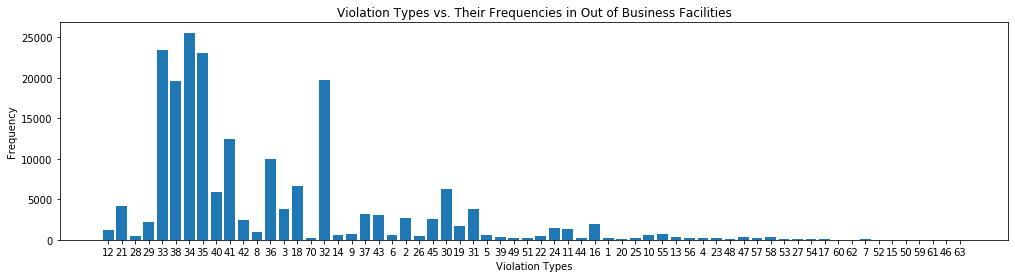

In [46]:
plt.figure(figsize=(17,4))
plt.bar(list(vio_freq_oob.keys()), vio_freq_oob.values())
plt.title('Violation Types vs. Their Frequencies in Out of Business Facilities')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

From the figure above, we can see that certain violation types outnumber the others. So, we decided to sort the violation types in terms of their frequencies and display them in the graph below.

In [0]:
sorted_vio_freq_oob = {}

for key in sorted(vio_freq_oob, key=vio_freq_oob.__getitem__, reverse=True):
  sorted_vio_freq_oob[key] = vio_freq_oob[key]

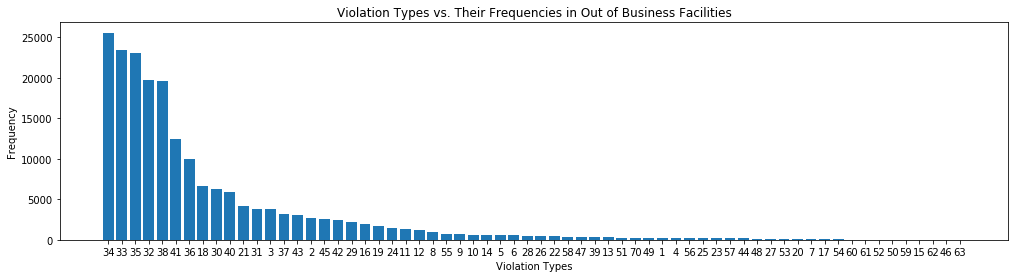

In [48]:
plt.figure(figsize=(17,4))
plt.bar(list(sorted_vio_freq_oob.keys()), sorted_vio_freq_oob.values())
plt.title('Violation Types vs. Their Frequencies in Out of Business Facilities')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

In [49]:
most_freq_vio_oob = [key for key, value in list(sorted_vio_freq_oob.items())[0:15]]
most_freq_vio_oob # top 10 most frequent violation types among facilities that went out of business

['34',
 '33',
 '35',
 '32',
 '38',
 '41',
 '36',
 '18',
 '30',
 '40',
 '21',
 '31',
 '3',
 '37',
 '43']

In [0]:
# Inspections of facilities that didn't go out of business
 set_diff_oob = pd.concat([df, merged_oob, merged_oob], sort=True).drop_duplicates(keep=False, subset=['Latitude', 'Longitude', 'DBA Name', 'License #', 'Inspection Date'])

In [51]:
set_diff_oob.dropna(subset=['Violations'], inplace=True) # the inspections that have violations (out of business facilities)
set_diff_oob.head(10)

,DBA Name,Facility Type,Inspection Date,Inspection ID,Inspection Type,Latitude,License #,Longitude,Results,Risk,Unnamed: 0,Violations,Zip
0,"CARNICERIA LEON GUANAJUATO, INC.",grocery store,2019-11-18T00:00:00.000,2345787,Canvass,41.916960,1821637.0,-87.733945,Fail,1,0,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",60639.0
1,AMSTAR FUEL & MINI MART,grocery store,2019-11-18T00:00:00.000,2345790,Canvass,41.895304,1426374.0,-87.721129,Pass,2,1,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",60651.0
2,ROJO GUSANO,restaurant,2019-11-18T00:00:00.000,2345766,Canvass,41.968390,1305286.0,-87.724448,Fail,1,2,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",60625.0
3,LAKESIDE FOOD WINE SPIRITS LLC,grocery store,2019-11-15T00:00:00.000,2345702,License Re-Inspection,41.929210,2694148.0,-87.648746,Pass w/ Conditions,3,3,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,60614.0
4,"NEW KNOWLEDGE LEARNING CENTER, INC.",children's services facility,2019-11-15T00:00:00.000,2345678,License,41.739458,2215898.0,-87.702257,Pass,1,4,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",60652.0
5,CARNICERIA MARIBEL INC,grocery store,2019-11-15T00:00:00.000,2345712,Canvass,41.852136,18057.0,-87.671058,Pass w/ Conditions,1,5,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",60608.0
6,ALCOCER'S LOCAL SHOP,grocery store,2019-11-15T00:00:00.000,2345690,Canvass,41.800637,2578896.0,-87.709274,Pass,1,6,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,60632.0
7,FAMOSA BAKERY,bakery,2019-11-15T00:00:00.000,2345664,Canvass Re-Inspection,41.793591,34128.0,-87.693228,Pass,2,7,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",60632.0
8,SHIBAM RESTAURANT,restaurant,2019-11-15T00:00:00.000,2345751,Canvass Re-Inspection,41.968344,2560481.0,-87.740310,Pass,1,8,41. WIPING CLOTHS: PROPERLY USED & STORED - Co...,60630.0
9,CIRCLE S MART INC.,grocery store,2019-11-15T00:00:00.000,2345695,Canvass,41.909518,2418830.0,-87.745960,Pass,1,9,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",60639.0


### **Violations analysis - facilities that have not gone out of business**

In [52]:
violations_not_oob = set_diff_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
violations_not_oob = pd.DataFrame(violations_not_oob)
violation_nums_not_oob = violations_not_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])
violation_nums_not_oob

0                               [3, 5, 23, 36, 38, 45]
1                                             [55, 56]
2           [3, 5, 25, 38, 47, 49, 51, 55, 55, 57, 58]
3                                          [5, 55, 56]
4                                         [53, 54, 56]
                              ...                     
191246                                [32, 33, 34, 41]
191248                            [33, 34, 35, 38, 41]
191250                                [31, 33, 34, 36]
191252    [18, 19, 32, 33, 34, 35, 36, 37, 38, 39, 41]
191254                            [18, 32, 34, 35, 36]
Name: Violations, Length: 97560, dtype: object

In [53]:
violation_nums_not_oob = pd.DataFrame(violation_nums_not_oob)
violation_nums_not_oob.reset_index(inplace=True)
violation_nums_not_oob.drop(columns='index', inplace=True)
violation_nums_not_oob.head(10)

,Violations
0,"[3, 5, 23, 36, 38, 45]"
1,"[55, 56]"
2,"[3, 5, 25, 38, 47, 49, 51, 55, 55, 57, 58]"
3,"[5, 55, 56]"
4,"[53, 54, 56]"
5,"[3, 5, 47, 57, 58]"
6,"[47, 58]"
7,"[3, 5]"
8,"[41, 47]"
9,"[55, 57]"


In [0]:
vio_freq_not_oob = {}
for i in violation_nums_not_oob['Violations']:
  for j in i:
    vio_freq_not_oob[str(j)] = 1 if str(j) not in vio_freq_not_oob else vio_freq_not_oob[str(j)]+1

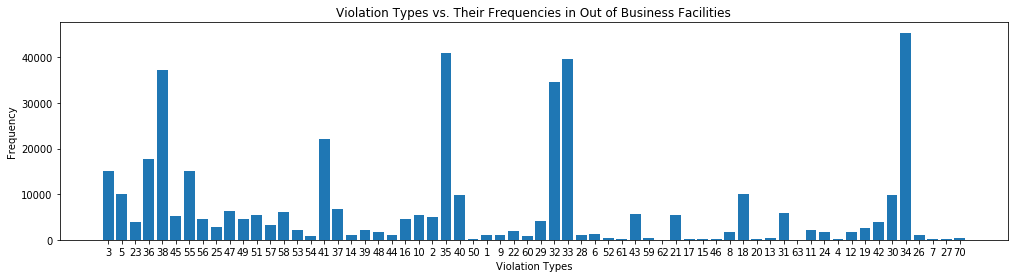

In [55]:
plt.figure(figsize=(17,4))
plt.bar(list(vio_freq_not_oob.keys()), vio_freq_not_oob.values())
plt.title('Violation Types vs. Their Frequencies in Out of Business Facilities')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

In [0]:
sorted_vio_freq_not_oob = {}

for key in sorted(vio_freq_not_oob, key=vio_freq_not_oob.__getitem__, reverse=True):
  sorted_vio_freq_not_oob[key] = vio_freq_not_oob[key]

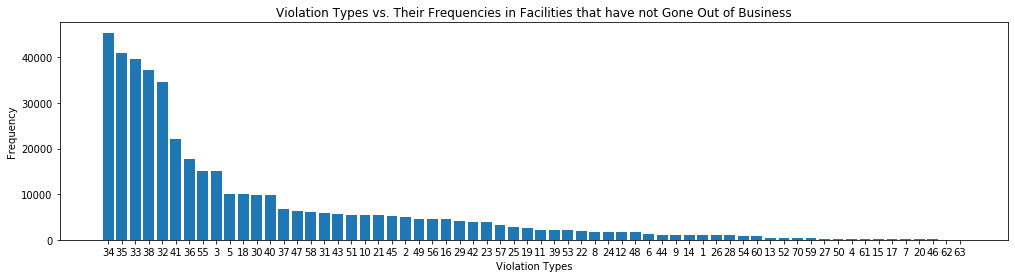

In [57]:
plt.figure(figsize=(17,4))
plt.bar(list(sorted_vio_freq_not_oob.keys()), sorted_vio_freq_not_oob.values())
plt.title('Violation Types vs. Their Frequencies in Facilities that have not Gone Out of Business')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

In [58]:
most_freq_vio_not_oob = [key for key, value in list(sorted_vio_freq_not_oob.items())[0:15]]
most_freq_vio_not_oob # top 10 most frequent violation types among facilities that went out of business

['34',
 '35',
 '33',
 '38',
 '32',
 '41',
 '36',
 '55',
 '3',
 '5',
 '18',
 '30',
 '40',
 '37',
 '47']

In [0]:
# Inspections of facilities that didn't go out of business
 set_diff_not_oob = pd.concat([df, set_diff_oob, set_diff_oob], sort=True).drop_duplicates(keep=False, subset=['Latitude', 'Longitude', 'DBA Name', 'License #', 'Inspection Date'])

In [60]:
set_diff_not_oob.dropna(subset=['Violations'], inplace=True) # the inspections that have violations (out of business facilities)
set_diff_not_oob.head(10)

,DBA Name,Facility Type,Inspection Date,Inspection ID,Inspection Type,Latitude,License #,Longitude,Results,Risk,Unnamed: 0,Violations,Zip
147,SUBWAY,restaurant,2019-11-08T00:00:00.000,2345318,Canvass Re-Inspection,41.927995,2529116.0,-87.785752,Pass w/ Conditions,1,149,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",60639.0
220,SUBWAY,restaurant,2019-11-06T00:00:00.000,2321166,Canvass,41.927995,2529116.0,-87.785752,Fail,1,222,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",60639.0
242,"TONO TACOS, INC.",restaurant,2019-11-06T00:00:00.000,2321204,Canvass,41.931211,2284711.0,-87.778615,Pass w/ Conditions,1,245,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",60639.0
284,MOY LEE RESTAURANT,restaurant,2019-11-05T00:00:00.000,2321106,Canvass,41.977764,28853.0,-87.769830,Pass w/ Conditions,1,288,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,60630.0
327,FIFTH CAMPUS,school,2019-11-01T00:00:00.000,2320922,Canvass,41.743149,2510248.0,-87.665746,Pass,2,331,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,60620.0
359,DEL SEOUL,restaurant,2019-10-31T00:00:00.000,2320878,Complaint,41.929448,2060126.0,-87.642925,Pass,1,363,35. APPROVED THAWING METHODS USED - Comments: ...,60614.0
611,RADAIOS BROS FRANKSVILLE INC,restaurant,2019-10-25T00:00:00.000,2320534,Complaint,41.944945,24224.0,-87.807141,Pass w/ Conditions,1,622,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERCO...,60634.0
698,RHYME OR REASON,restaurant,2019-10-24T00:00:00.000,2320407,Canvass Re-Inspection,41.903314,1985220.0,-87.676417,Pass,1,709,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,60622.0
864,AVENIDA DEL SABOR,restaurant,2019-10-18T00:00:00.000,2316061,Canvass Re-Inspection,41.931095,2488459.0,-87.771344,Pass w/ Conditions,1,875,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERCO...,60639.0
944,RHYME OR REASON,restaurant,2019-10-17T00:00:00.000,2316016,Canvass,41.903314,1985220.0,-87.676417,Fail,1,956,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,60622.0


Our aim was to detect any violation type that could result into the facilities going out of business. From our data analysis, we found that most violation types are common between those that went out of business and those that have not. Only Violation Types 21, 31, and 43 are more prevalent in facilities that have gone out of business, but are not so prevalent in those that have not gone out of business.

### **Average number of total violations facilities commit before going out of business**  

### **Distribution of number of violations committed in each inspection (in facilities that went out of business)**

In [67]:
num_vio_oob = []
for i in violation_nums_oob['Violations']:
  num_vio_oob.append(len(i))

print(num_vio_oob)

[6, 8, 7, 5, 5, 3, 6, 3, 9, 2, 5, 7, 7, 4, 8, 7, 6, 2, 2, 9, 1, 3, 2, 3, 1, 5, 3, 5, 2, 4, 3, 5, 6, 4, 4, 4, 4, 4, 2, 6, 4, 3, 2, 9, 7, 11, 4, 9, 2, 1, 5, 3, 4, 6, 1, 1, 3, 5, 1, 4, 3, 2, 2, 2, 1, 5, 8, 3, 3, 6, 7, 1, 2, 3, 3, 5, 7, 5, 5, 8, 6, 4, 5, 1, 8, 4, 12, 8, 3, 8, 7, 10, 1, 2, 10, 3, 1, 6, 5, 4, 4, 7, 7, 4, 10, 14, 10, 12, 2, 2, 2, 8, 3, 3, 5, 3, 2, 8, 11, 2, 8, 4, 6, 10, 3, 1, 2, 4, 4, 2, 4, 1, 5, 2, 9, 6, 5, 7, 7, 9, 11, 3, 3, 9, 7, 5, 4, 2, 4, 2, 3, 4, 6, 1, 7, 2, 4, 6, 11, 9, 2, 6, 1, 2, 2, 10, 10, 9, 9, 9, 4, 6, 8, 8, 6, 2, 3, 11, 14, 14, 7, 10, 7, 7, 10, 2, 5, 8, 9, 4, 1, 4, 1, 2, 1, 2, 9, 3, 5, 7, 9, 3, 2, 3, 2, 4, 2, 3, 1, 19, 5, 3, 9, 5, 4, 6, 3, 1, 10, 9, 12, 5, 8, 8, 12, 5, 6, 6, 4, 7, 7, 5, 6, 8, 1, 3, 3, 4, 5, 3, 2, 1, 2, 2, 4, 1, 4, 2, 2, 2, 5, 9, 11, 1, 6, 9, 7, 9, 7, 8, 12, 4, 8, 3, 2, 6, 3, 8, 1, 6, 3, 4, 6, 4, 2, 2, 3, 2, 2, 4, 7, 2, 8, 7, 3, 3, 2, 1, 4, 6, 3, 6, 4, 4, 4, 4, 5, 3, 2, 3, 4, 1, 12, 3, 7, 5, 14, 7, 3, 4, 2, 2, 1, 3, 2, 2, 2, 2, 3, 4, 7, 1, 11, 5,

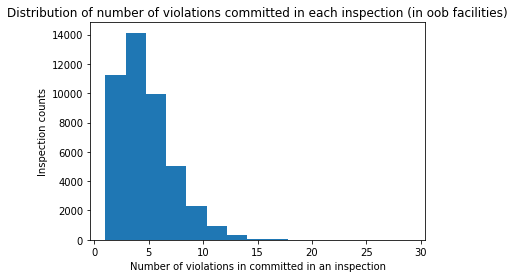

In [81]:
plt.hist(num_vio_oob, bins=15)
plt.title('Distribution of number of violations committed in each inspection (in oob facilities)')
plt.xlabel('Number of violations in committed in an inspection')
plt.ylabel('Inspection counts')
plt.show()

### **Average number of violations committed in each inspection (in facilities that went out of business)**

In [84]:
np.mean(num_vio_oob)

4.499932077522188

### **Distribution of number of violations committed in each inspection (in facilities that did NOT go out of business)**

In [82]:
num_vio_not_oob = []
for i in violation_nums_not_oob['Violations']:
  num_vio_not_oob.append(len(i))

print(num_vio_not_oob)

[6, 2, 11, 3, 3, 5, 2, 2, 2, 2, 7, 8, 1, 10, 18, 11, 5, 7, 2, 7, 11, 7, 7, 16, 16, 3, 9, 8, 3, 5, 7, 2, 5, 4, 9, 7, 20, 7, 1, 7, 6, 6, 5, 11, 1, 2, 13, 1, 2, 8, 5, 9, 6, 6, 4, 13, 11, 2, 5, 7, 11, 4, 2, 3, 4, 4, 9, 15, 4, 3, 3, 1, 3, 8, 3, 5, 6, 2, 2, 4, 1, 4, 11, 4, 2, 4, 12, 6, 4, 13, 3, 12, 4, 5, 9, 1, 2, 2, 4, 3, 4, 6, 8, 5, 6, 5, 4, 9, 1, 4, 6, 9, 5, 6, 1, 3, 3, 4, 8, 3, 12, 1, 9, 9, 4, 10, 7, 16, 5, 5, 3, 5, 7, 6, 1, 7, 3, 6, 4, 14, 12, 1, 17, 10, 3, 1, 6, 5, 6, 14, 8, 9, 1, 9, 5, 6, 1, 4, 7, 12, 1, 3, 8, 7, 15, 22, 3, 8, 12, 2, 2, 5, 8, 16, 6, 13, 11, 9, 2, 2, 5, 1, 2, 15, 3, 6, 6, 15, 3, 3, 2, 6, 6, 11, 1, 4, 3, 2, 1, 5, 9, 2, 6, 5, 9, 2, 10, 11, 7, 3, 1, 1, 7, 5, 10, 6, 5, 8, 2, 5, 1, 8, 16, 7, 4, 3, 5, 3, 11, 3, 4, 9, 2, 2, 9, 6, 3, 8, 13, 1, 1, 8, 2, 6, 3, 1, 8, 6, 1, 1, 15, 8, 7, 4, 4, 5, 3, 5, 4, 3, 1, 1, 5, 5, 4, 2, 2, 11, 12, 3, 1, 7, 5, 1, 1, 2, 1, 7, 8, 2, 3, 2, 6, 4, 5, 4, 2, 22, 2, 12, 5, 5, 6, 2, 6, 2, 2, 10, 1, 1, 6, 14, 11, 3, 9, 1, 1, 3, 4, 13, 14, 6, 4, 1, 1, 8,

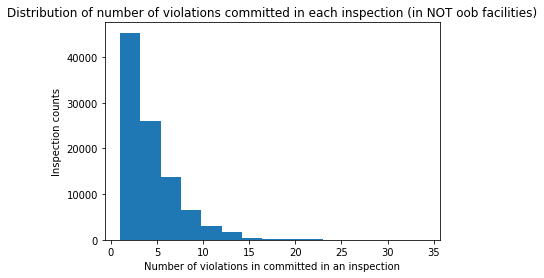

In [83]:
plt.hist(num_vio_not_oob, bins=15)
plt.title('Distribution of number of violations committed in each inspection (in NOT oob facilities)')
plt.xlabel('Number of violations in committed in an inspection')
plt.ylabel('Inspection counts')
plt.show()

### **Average number of violations committed in each inspection (in facilities that did NOT go out of business)**

In [85]:
np.mean(num_vio_not_oob)

4.372990979909799

### **Distribution of total number of violations facilities commit before going out of business**

In [88]:
oob_grouped_by_fac = merged_oob.groupby(['Latitude', 'Longitude', 'DBA Name', 'License #'])
oob_grouped_by_fac.head(10)

,Latitude,Longitude,DBA Name,License #,Unnamed: 0,Inspection ID,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Violations
0,41.644670,-87.540095,BURGER KING #7268,1473518.0,95174,1527281,restaurant,2,60633.0,2015-02-23T00:00:00.000,Canvass,Out of Business,NaN
1,41.644670,-87.540095,BURGER KING #7268,1473518.0,105889,1494060,restaurant,2,60633.0,2014-08-26T00:00:00.000,Canvass Re-Inspection,Pass,NaN
2,41.644670,-87.540095,BURGER KING #7268,1473518.0,106477,1493718,restaurant,2,60633.0,2014-08-18T00:00:00.000,Canvass,Fail,12. HAND WASHING FACILITIES: WITH SOAP AND SAN...
3,41.644670,-87.540095,BURGER KING #7268,1473518.0,140719,1300984,restaurant,2,60633.0,2012-12-19T00:00:00.000,Canvass,Pass w/ Conditions,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...
4,41.644670,-87.540095,BURGER KING #7268,1473518.0,158865,537818,restaurant,2,60633.0,2012-01-10T00:00:00.000,Short Form Complaint,Pass w/ Conditions,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67358,42.020753,-87.672934,HOWARD AREA ALTERNATIVE HIGH SCHOOL,2510907.0,135089,1326791,school,1,60626.0,2013-04-08T00:00:00.000,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...
67359,42.020753,-87.672934,HOWARD AREA ALTERNATIVE HIGH SCHOOL,2510907.0,144419,1285809,school,1,60626.0,2012-10-11T00:00:00.000,Canvass Re-Inspection,Pass,"41. PREMISES MAINTAINED FREE OF LITTER, UNNECE..."
67360,42.020753,-87.672934,HOWARD AREA ALTERNATIVE HIGH SCHOOL,2510907.0,144763,1106356,school,1,60626.0,2012-10-04T00:00:00.000,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
67361,42.020753,-87.672934,HOWARD AREA ALTERNATIVE HIGH SCHOOL,2510907.0,152408,1214975,school,1,60626.0,2012-05-17T00:00:00.000,Canvass Re-Inspection,Pass w/ Conditions,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...


### **Average number of each violation type facilities commit before going out of business**

### **Average number of violations facilities commit at each inspection before going out of business**

### **Average risk of oob facilities vs. Average risk of NOT oob facilities**

### **Does the frequency of inspections increase once you fail?**




## **Our plan for the future:**



- Analyze neighborhoods, taking a deep look into the locations of the facilities, and plotting the neighborhoods on the map (adding the region names on the map)
- Look for hidden reasons why facilities go out of business, taking NLP approaches to process and find out the most frequent violation types
- The trends (risk, violation types, pass/fail results, etc.) facilities follow until they go out of business
- Look for the #1 violation type of the neighborhood
- Prepare poster presentation